In [1]:
import numpy as np
import itertools
import numpy.linalg as LA
import pandas as pd

In [12]:
# Is \overline{A*B}^T(A*B) faster than LA.norm(A*B, 'fro')
A = np.random.rand(784).reshape((28,28))
B = np.random.rand(784).reshape((28,28))

In [13]:
%%timeit

np.trace((A*B).T.dot(A*B))

23.7 µs ± 124 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [14]:
%%timeit

LA.norm(A*B, 'fro')

13.4 µs ± 867 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [21]:
def similarity(sample):
    """ Find the similarity matrix for a sample taken from a class of digits. """
    
    N = len(sample)
    
    agree = [LA.norm(A*B,'fro')/(np.sqrt(LA.norm(A*A,'fro'))*np.sqrt(LA.norm(B*B,'fro'))) for A in sample for B in sample]
    
#     agree_chart = pd.DataFrame(np.array(agree).reshape(N,N))
#     agree_chart[agree_chart > 0.99] = 0
    
#     return agree_chart

def similarity2(sample):
    """ Find the similarity matrix for a sample taken from a class of digits. """
    
    N = len(sample)
    
    def sim(cartesian_product):
        """ Take in a tuple and compute the similarity of its elements """
        return [LA.norm(A*B,'fro')/(np.sqrt(LA.norm(A*A,'fro'))*np.sqrt(LA.norm(B*B,'fro'))) for (A,B) in cartesian_product]
    
    agree = sim(list(itertools.product(sample, sample)))
    
#     agree_chart = pd.DataFrame(np.array(agree).reshape(N,N))
#     agree_chart[agree_chart > 0.99] = 0
    
#     return agree_chart

In [22]:
%%timeit

similarity([A,B])

169 µs ± 2.45 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [23]:
%%timeit

similarity2([A,B])

172 µs ± 3.11 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [37]:
list(itertools.product([A,B]))

2

In [39]:
%%timeit

def sim(A, B):
    """ Take in a tuple and compute the similarity of its elements """
#     return LA.norm(A*B,'fro')/(np.sqrt(LA.norm(A*A,'fro'))*np.sqrt(LA.norm(B*B,'fro')))
    return A + B

samples = ['A','B','C','D','E']

data = itertools.product(samples, samples)

list(itertools.starmap(sim, data)) 

4.74 µs ± 22.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [41]:
%%timeit
def dumb(samples):
    return [sim(A,B) for A in samples for B in samples]

dumb(samples)

6.15 µs ± 598 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Trying the above with the image data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import morphology as morph
from scipy.signal import fftconvolve, correlate
import numpy.linalg as LA
from sklearn.datasets import fetch_openml
import copy
import itertools
import time

In [3]:
# Load MNIST data from https://www.openml.org/d/554
images, labels = fetch_openml('mnist_784', version=1, return_X_y=True)

In [4]:
''' Right now the images and labels are in separate arrays. 
    I'll put them into a single pandas DataFrame to make it
    easier to sort by label.
'''

images = pd.DataFrame(zip(images,labels), columns = ['Image','Class label'])

# Not really necessary, but I'll sort the images by class label.
images.sort_values(by = 'Class label', inplace = True)

# By default, the 'Class label' column is not integer, so we'll convert it here.
images['Class label'] = images['Class label'].apply(int)

# The images are also flattened, so we'll reshape them to (28,28)
images['Image'] = images['Image'].apply(lambda x: x.reshape((28,28)))

In [5]:
def extract_image(frame, digit):
    """ This function takes in a dataset containing images. 
        The set is converted to a DataFrame, and the images
        corresponding to the given digit are extracted.
        
        An array containing images of the given digit is
        returned.
    """
        
    ims = frame[frame['Class label'] == digit]
    
    # Now ims only contains labels matching the digit, so we can drop the label column.
    ims = ims.drop('Class label', axis = 1)
    
    return np.array(ims['Image'])

def display_lengths(data):
    """ Display the total length of each subset of digits. 
    
        Used for checking that the conversion worked as expected.
    """
    
    for i in range(10):
        print('{} examples of digit {}'.format(len(data[i]), i))
    print('{} examples in total\n'.format(sum(len(data[i]) for i in range(10))))
    return None

In [6]:
data = [extract_image(images, i) for i in range(10)]
display_lengths(data)

6903 examples of digit 0
7877 examples of digit 1
6990 examples of digit 2
7141 examples of digit 3
6824 examples of digit 4
6313 examples of digit 5
6876 examples of digit 6
7293 examples of digit 7
6825 examples of digit 8
6958 examples of digit 9
70000 examples in total



In [7]:
# Finally, save each digit separately

zero = data[0]
one = data[1]
two = data[2]
three = data[3]
four = data[4]
five = data[5]
six = data[6]
seven = data[7]
eight = data[8]
nine = data[9]

In [8]:
# Take N samples from each digit

N = 10

sample0 = zero[:N]
sample1 = one[:N]
sample2 = two[:N]
sample3 = three[:N]
sample4 = four[:N]
sample5 = five[:N]
sample6 = six[:N]
sample7 = seven[:N]
sample8 = eight[:N]
sample9 = nine[:N]

In [9]:
samples = [sample0, sample1, sample2, sample3, sample4, sample5, sample6, sample7, sample8, sample9]

In [10]:
# %%timeit
def sim(A, B):
    """ Take in a tuple and compute the similarity of its elements """
    
#     print((A*B).shape)
#     plt.imshow(pair[0], cmap = 'gray');
#     plt.imshow(B, cmap = 'gray');
    return LA.norm(A*B,'fro')/(np.sqrt(LA.norm(A*A,'fro'))*np.sqrt(LA.norm(B*B,'fro')))

def similarity(sample):
    """ Find the similarity matrix for a sample taken from a class of digits. """
    
    N = len(sample)
    
    agree = [LA.norm(A*B,'fro')/(np.sqrt(LA.norm(A*A,'fro'))*np.sqrt(LA.norm(B*B,'fro'))) for A in sample for B in sample]
    
    agree_chart = pd.DataFrame(np.array(agree).reshape(N,N))
    agree_chart[agree_chart > 0.99] = 0
    
    return agree_chart

# samples = ['A','B','C','D','E']

data = list(itertools.product(sample3, sample3))
ag = list(itertools.starmap(sim, data))
# ag = [sim(A,B) for (A,B) in data]

In [60]:
def sim(A, B):
    """ Take in a tuple and compute the similarity of its elements """
    
#     print((A*B).shape)
#     plt.imshow(pair[0], cmap = 'gray');
#     plt.imshow(B, cmap = 'gray');
    return LA.norm(A*B,'fro')/(np.sqrt(LA.norm(A*A,'fro'))*np.sqrt(LA.norm(B*B,'fro')))

def similarity(sample):
    """ Find the similarity matrix for a sample taken from a class of digits. """
    
    N = len(sample)
       
    agree = [LA.norm(A*B,'fro')/(np.sqrt(LA.norm(A*A,'fro'))*np.sqrt(LA.norm(B*B,'fro'))) for A in sample for B in sample]
    
    agree_chart = pd.DataFrame(np.array(agree).reshape(N,N))
    agree_chart[agree_chart > 0.99] = 0
    
    return agree_chart

# samples = ['A','B','C','D','E']

data = list(itertools.product(sample3, sample3))
# ag = list(itertools.starmap(sim, data))

ag = np.array(list(sim(A,B) for (A,B) in data))

In [65]:
%%timeit

ag_chart = pd.DataFrame(ag.reshape((N,N)))
ag_chart[ag_chart > 0.99] = 0

4.94 ms ± 173 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [52]:
%%timeit
agreement_charts = [similarity(sample) for sample in samples]

110 ms ± 2.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [53]:
%%timeit
agreement_charts = [similarity2(sample) for sample in samples]

109 ms ± 534 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Trying to put this in parallel to save time

In [11]:
import multiprocessing

num_cores = multiprocessing.cpu_count()
print(num_cores)

8


In [ ]:
start = time.time()
pool = multiprocessing.Pool(8)
ag_charts = zip(*pool.map(similarity, samples))
end = time.time()
print(end - start)

# Can we vectorize the similarity function?

In [2]:
def sim(A, B):
    """ Take in a tuple and compute the similarity of its elements """
    
    return LA.norm(A*B,'fro')/(np.sqrt(LA.norm(A*A,'fro'))*np.sqrt(LA.norm(B*B,'fro')))

In [38]:
data = list(itertools.product(samples, samples))

In [39]:
len(data[0])

2

In [18]:
data[0]

array([[array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,  34., 253.,  69.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,  

In [26]:
dt = np.array(list(itertools.product([1,2],[3,4])))
dt

array([[1, 3],
       [1, 4],
       [2, 3],
       [2, 4]])

In [33]:
dt.argmax()

3

# Questions/Ideas

* Should I bother flattening the images? Element-wise addition and multiplication should be the same for vectors as it is for matrices, so it seems that there's no need to flatten the images.
* I don't think there's any way to speed up the data loading step, but I can probably simplify the use of `pandas` for storing and sorting the data.
* Can I make the calculation of the similarity faster? I think I'm doing more than double the calculations necessary.
* Can kNN be used to find digit families?
* The images are currently all expressed as floats. Will changing their type to integer speed things up?

In [1]:
import numpy as np

In [2]:
A = np.random.rand(100)

In [9]:
%%timeit

np.dot(A, A)

1.99 µs ± 89.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [5]:
%%timeit

total = 0

for element in A:
    total += element**2
    
total

97.3 µs ± 1.13 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [7]:
%%timeit

dot = []

for element in A:
    dot.append(element**2)
    
total = np.sum(dot)

117 µs ± 1.74 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Function to divide images into 4 equal quadrants

- Find the dimensions of the image
- If either the width or length of the image is odd, pad with zeros (need zero padding function)

Example: an image has size 14x13. 14 is divisible by 2, but 13 is not. Therefore, we pad the image with zeros along the second axis. We then divide the 14x14 padded image into 4 equal parts, remove the pad, and return the 4 quadrants as a list of images.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
def image_quadrants(image):
    """ Function to divide an image into 4 equal quadrants (with zero padding if necessary). """
    
    height, width = image.shape
    
    if not height % 2:
        new_height = height + 1
    if not width % 2:
        new_width = width + 1
    else:
        new_height, new_width = height, width
    
    # Create an image of zeros, fill in the matching indices with the original image
    pad = np.zeros((new_height, new_width))
    
    pad[:height, :width] = image
    
    half_height, half_width = new_height//2, new_width//2
    
    return [pad[:half_height, :half_width], pad[:half_height, half_width:], pad[half_height:, :half_width], pad[half_height:, half_width:]]

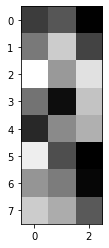

In [24]:
test_im = np.random.rand(24).reshape((8,3))
plt.imshow(test_im, cmap = 'gray');

im2 = image_quadrants(test_im)

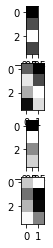

In [25]:
fig, ax = plt.subplots(len(im2))

for axis, im in zip(ax, im2):
    axis.imshow(im, cmap = 'gray');